# Singular Spectrum Analysis for Time Series in Python

Import the main library and pandas and numpy for use outside the main library.

In [2]:
from pssa import mySSA

import pandas as pd
import numpy as np

In [11]:
# First enable display of graphs in the notebook
%matplotlib inline 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

Read in the file as an example:

In [50]:
ts = pd.read_csv('data/AirPassengers.csv', parse_dates=True, index_col='Month')

In [65]:
# ts.loc['1949-01-01':'1949-12-01']=None
ts.loc['1955-01-01':'1956-7-01']=None
ts.loc['1958-03-01':'1958-10-01']=None

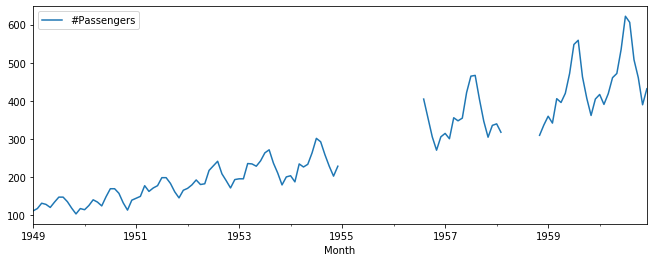

In [66]:
ts.plot()

Instantiate the ssa object with the time series

In [67]:
ssa = mySSA(ts)

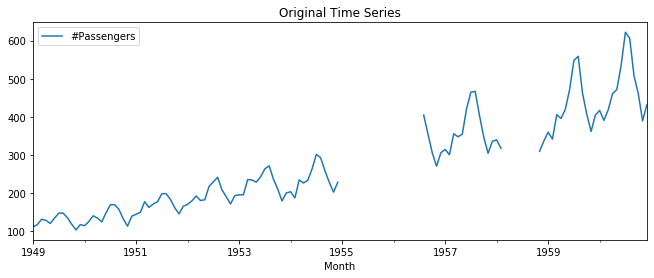

In [68]:
ssa.ts.plot(title='Original Time Series');

The methods and attributes currently associated with the object is listed below:

In [69]:
[x for x in dir(ssa) if  x[0]!='_']

['decompose',
 'diagonal_averaging',
 'embed',
 'forecast_recurrent',
 'freq',
 'get_contributions',
 'ts',
 'ts_N',
 'ts_name',
 'ts_v',
 'view_reconstruction',
 'view_s_contributions',
 'view_time_series']

The general procedure in SSA is as follows:
1. **Embed** the time series by forming a Hankel matrix of lagged window (length K) vectors.
2. **Decompose** the embedded time series via Singular Value Decomposition
3. **Eigentripple Grouping** is the process of identifying eigenvalue-eigenvector pairs as *trend*, *seasonal* and *noise*
4. **Reconstruct** the time series from the eigenvalue-eigenvector pairs identified as *trend* and *seasonal*.  This is done through a process called *diagonal averaging*.

In [70]:
K = 40
suspected_seasonality = 12

In [71]:
ssa.embed(embedding_dimension=40, suspected_frequency=suspected_seasonality, verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  36
Trajectory dimensions	: (36, 109)
Complete dimension	: (36, 37)
Missing dimension     	: (36, 72)


In [77]:
ssa.decompose(verbose=True)

----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 36
Dimension of projection space	: 16
Characteristic of projection	: 0.9997


We can view the contribution of each of the signals (corresponding to each singular value) as follows:

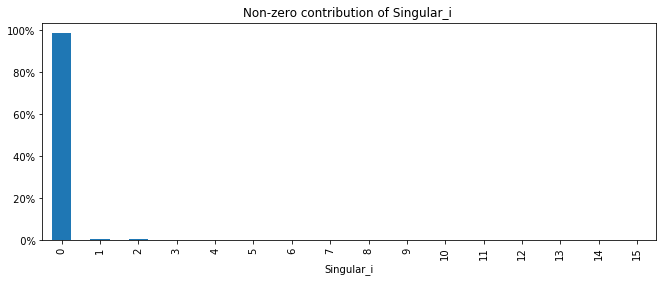

In [78]:
ssa.view_s_contributions()

From the above we can see that most of the variation is contained in the first signal (corresponding to the first singular vector).  The scale in the image above makes it difficult to see what's going on with the remaining singular values.  

Pass the argument  `adjust_scale=True` to see the eigenvalue groupings more clearly.  The scale on the y-axis is meaningless and is removed in this case.

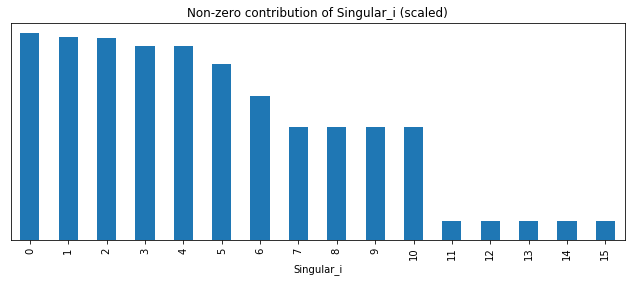

In [79]:
ssa.view_s_contributions(adjust_scale=True)

Now that we have the signal components (there are 15 additive components to the signal) we can loop over that range and look at each one individually.  We only look at the first 5 elements below:

*The additive signal elements are stored in the* `object.Xs` *dictionary.*

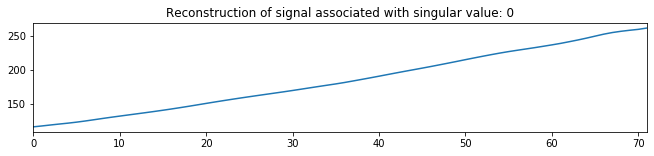

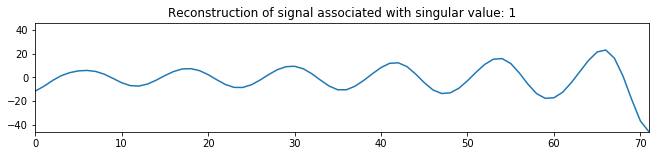

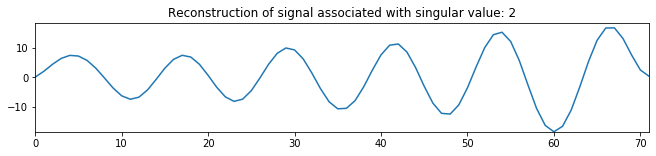

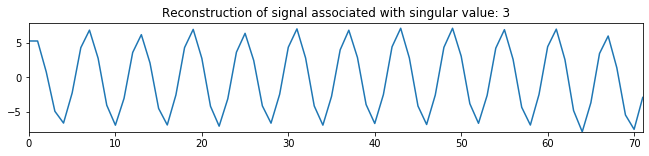

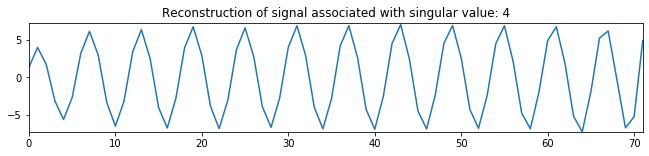

In [75]:
rcParams['figure.figsize'] = 11, 2
for i in range(5):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

Let's see the result if we reconstruct the signal from these 5 streams.  We add the first 5 signals and pass the result to `object.view_reconstruction`:

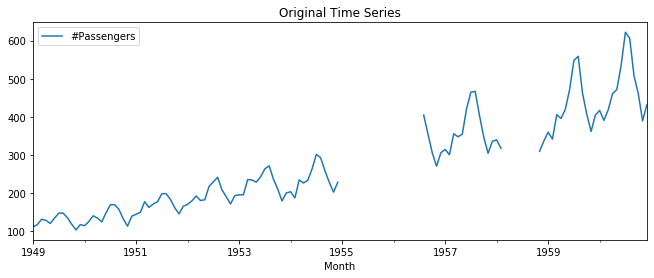

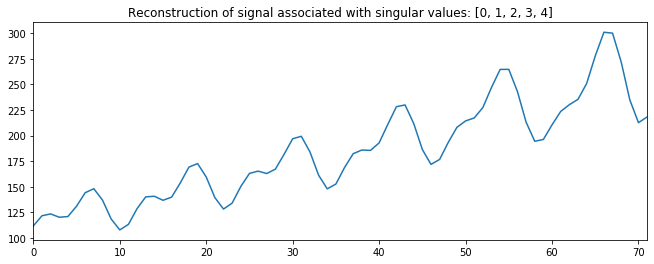

In [76]:
ssa.ts.plot(title='Original Time Series'); # This is the original series for comparison
streams5 = [i for i in range(5)]
reconstructed5 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams5], names=streams5, return_df=True)

We see that the reconstruction looks pretty good already! Let's plot it on the same graph:

In [64]:
reconstructed5

,Reconstruction
0,111.663836
1,121.581630
2,123.413089
3,120.133985
4,120.829807
...,...
67,300.026528
68,271.870307
69,234.759416
70,212.533318


In [63]:
ts_copy5 = ssa.ts.copy()
ts_copy5['Reconstruction'] = reconstructed5.Reconstruction.values
ts_copy5.plot(title='Original vs. Reconstructed Time Series');

ValueError: Length of values does not match length of index

That looks very reasonable! We can get closer to the original series by adding additional signals from the remaining singular values.  Let's use the first 10 singular values:

In [47]:
streams10 = [i for i in range(10)]
reconstructed10 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams10], 
                                          names=streams10, return_df=True, plot=False)
ts_copy10 = ssa.ts.copy()
ts_copy10['Reconstruction'] = reconstructed10.Reconstruction.values
ts_copy10.plot(title='Original vs. Reconstructed Time Series');

ValueError: Length of values does not match length of index

To forecast using only some of the singular values, pass the list of singular value indices to be used to the `forecast_recurrent` method:

In [48]:
ssa.forecast_recurrent(steps_ahead=48, singular_values=streams10, plot=True)

ValueError: shapes (1,35) and (1,1) not aligned: 35 (dim 1) != 1 (dim 0)

That concludes our example.  As a demonstration of how powerful this technique is, let's forecast this series 1x the length of the original time series:

In [49]:
rcParams['figure.figsize'] = 11,8
ssa.forecast_recurrent(steps_ahead=ssa.ts.shape[0], singular_values=streams10, plot=True)
rcParams['figure.figsize'] = 11, 4

ValueError: shapes (1,35) and (1,1) not aligned: 35 (dim 1) != 1 (dim 0)

Quite impressive!  Enjoy!